In [4]:
# Installing all required libraries

# Core ML libraries
!pip install numpy pandas scikit-learn xgboost lightgbm

# Deep learning library
!pip install tensorflow

# Explainability library
!pip install shap

# Plotting libraries (usually preinstalled, but included for safety)
!pip install matplotlib seaborn

print ("All installations complete.")


All installations complete.


In [5]:
# Core imports and basic setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 5)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Fixing random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports successful and environment configured")

# Import custom library
import sys
sys.path.append('.')
from src.utils import generate_synthetic_weather, add_lags_and_rolling


Imports successful and environment configured


In [6]:
# Step 2: Load raw AQI data

station_hour_path = "station_hour.csv"
stations_path = "stations.csv"

station_hour = pd.read_csv(station_hour_path)
stations = pd.read_csv(stations_path)

print("station_hour shape:", station_hour.shape)
print("stations shape:", stations.shape)

display(station_hour.head())
display(stations.head())


/tmp/ipykernel_76/602081316.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_hour = pd.read_csv(station_hour_path)


station_hour shape: (2589083, 16)
stations shape: (230, 5)


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,126.40,0.1,6.10,0.10,NaN,NaN
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,117.12,0.1,6.25,0.15,NaN,NaN
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,98.98,0.2,5.98,0.18,NaN,NaN
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,112.20,0.2,6.72,0.10,NaN,NaN
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,106.35,0.2,5.75,0.08,NaN,NaN


,StationId,StationName,City,State,Status
0,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
1,AP002,"Anand Kala Kshetram, Rajamahendravaram - APPCB",Rajamahendravaram,Andhra Pradesh,NaN
2,AP003,"Tirumala, Tirupati - APPCB",Tirupati,Andhra Pradesh,NaN
3,AP004,"PWD Grounds, Vijayawada - APPCB",Vijayawada,Andhra Pradesh,NaN
4,AP005,"GVM Corporation, Visakhapatnam - APPCB",Visakhapatnam,Andhra Pradesh,Active


In [7]:
# Step 3: Clean datetime and merge with station metadata

# Converting the Datetime column to pandas datetime
station_hour["Datetime"] = pd.to_datetime(station_hour["Datetime"], errors="coerce")

# Dropping any rows where Datetime could not be parsed
station_hour = station_hour.dropna(subset=["Datetime"])

# Merging hourly data with station info to get City, State, StationName
df = station_hour.merge(stations, on="StationId", how="left")

# Sorting by StationId and Datetime to keep time-series order
df = df.sort_values(["StationId", "Datetime"]).reset_index(drop=True)

print("Merged dataframe shape:", df.shape)
display(df.head())


Merged dataframe shape: (2589083, 20)


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,StationName,City,State,Status
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,126.40,0.1,6.10,0.10,NaN,NaN,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,117.12,0.1,6.25,0.15,NaN,NaN,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,98.98,0.2,5.98,0.18,NaN,NaN,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,112.20,0.2,6.72,0.10,NaN,NaN,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,106.35,0.2,5.75,0.08,NaN,NaN,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active


In [8]:
# Step 4: Basic sanity checks on merged data

print("Basic info about df:")
print(df.info())

print("\nSample of numeric summary stats:")
num_df = df.select_dtypes(include=["float64", "int64"])
display(num_df.describe().T.head(15))

print("\nTop 10 cities by number of records:")
city_counts = df["City"].value_counts().head(10)
display(city_counts)


Basic info about df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589083 entries, 0 to 2589082
Data columns (total 20 columns):
 #   Column       Dtype         
---  ------       -----         
 0   StationId    object        
 1   Datetime     datetime64[ns]
 2   PM2.5        float64       
 3   PM10         float64       
 4   NO           float64       
 5   NO2          float64       
 6   NOx          float64       
 7   NH3          float64       
 8   CO           float64       
 9   SO2          float64       
 10  O3           float64       
 11  Benzene      float64       
 12  Toluene      float64       
 13  Xylene       float64       
 14  AQI          float64       
 15  AQI_Bucket   object        
 16  StationName  object        
 17  City         object        
 18  State        object        
 19  Status       object        
dtypes: datetime64[ns](1), float64(13), object(6)
memory usage: 395.1+ MB
None

Sample of numeric summary stats:


,count,mean,std,min,25%,50%,75%,max
PM2.5,1941394.0,80.864814,89.476181,0.01,28.16,52.59,97.74,1000.00
PM10,1469831.0,158.483906,139.788258,0.01,64.00,116.25,204.00,1000.00
NO,2035372.0,22.788253,48.461463,0.01,3.05,7.15,18.58,500.00
NO2,2060110.0,35.236891,34.975083,0.01,13.10,24.79,45.48,499.99
NOx,2098275.0,40.551148,55.908938,0.00,11.35,22.86,45.70,500.00
NH3,1352465.0,28.708556,27.532443,0.01,11.23,22.35,37.78,499.97
CO,2089781.0,1.502366,6.292445,0.00,0.41,0.80,1.38,498.57
SO2,1846346.0,12.116025,14.673848,0.01,4.25,8.25,14.53,199.96
O3,1863110.0,38.064085,47.106533,0.01,11.02,24.75,49.53,997.00
Benzene,1727504.0,3.305493,12.140528,0.00,0.08,0.96,3.23,498.07



Top 10 cities by number of records:


City
Delhi        1087388
Bengaluru     287564
Hyderabad     209831
Chennai       153648
Lucknow       146210
Mumbai        131750
Kolkata        75717
Jaipur         74032
Gurugram       67804
Patna          64031
Name: count, dtype: int64

In [9]:
# Step 5: Select top 6 cities with highest data availability

top_cities = df["City"].value_counts().head(6).index.tolist()
print("Top cities selected:", top_cities)

# Filtering the main dataframe to only these cities
df_work = df[df["City"].isin(top_cities)].copy()

print("Filtered dataset shape:", df_work.shape)
display(df_work.head())


Top cities selected: ['Delhi', 'Bengaluru', 'Hyderabad', 'Chennai', 'Lucknow', 'Mumbai']
Filtered dataset shape: (2016391, 20)


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,StationName,City,State,Status
141133,DL001,2018-11-11 15:00:00,130.00,274.00,1.70,54.00,30.10,NaN,0.80,26.40,NaN,3.40,15.30,0.10,NaN,NaN,"Alipur, Delhi - DPCC",Delhi,Delhi,Active
141134,DL001,2018-11-11 16:00:00,133.25,279.00,1.70,55.07,30.67,25.55,0.83,27.97,NaN,3.68,15.08,0.10,NaN,NaN,"Alipur, Delhi - DPCC",Delhi,Delhi,Active
141135,DL001,2018-11-11 17:00:00,140.25,284.25,1.58,55.88,30.97,24.30,0.85,24.80,105.23,3.33,12.27,0.10,NaN,NaN,"Alipur, Delhi - DPCC",Delhi,Delhi,Active
141136,DL001,2018-11-11 18:00:00,153.25,332.00,1.63,64.05,35.40,28.57,1.53,20.25,83.53,3.85,13.33,0.15,NaN,NaN,"Alipur, Delhi - DPCC",Delhi,Delhi,Active
141137,DL001,2018-11-11 19:00:00,247.00,575.00,1.75,80.07,43.98,37.90,1.68,18.00,53.57,6.80,19.02,0.30,NaN,NaN,"Alipur, Delhi - DPCC",Delhi,Delhi,Active


In [10]:
# Step 6: IQR-based outlier removal for pollutant columns

# Selecting pollutant columns (numeric only)
pollutant_cols = ["PM2.5", "PM10", "NO", "NO2", "NOx", "NH3", "CO", "SO2", "O3",
                  "Benzene", "Toluene", "Xylene", "AQI"]

df_clean = df_work.copy()

rows_before = df_clean.shape[0]

for col in pollutant_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clipping values instead of dropping to preserve data
    # (clipping is safer than dropping millions of rows)
    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)

rows_after = df_clean.shape[0]

print("Rows before cleaning:", rows_before)
print("Rows after cleaning :", rows_after)
print("No rows removed, only extreme values clipped.")


Rows before cleaning: 2016391
Rows after cleaning : 2016391
No rows removed, only extreme values clipped.


In [11]:
# Step 7: Add datetime-based features

df_feat = df_clean.copy()

# Extracting hour, weekday, month
df_feat["hour"] = df_feat["Datetime"].dt.hour
df_feat["weekday"] = df_feat["Datetime"].dt.weekday  # Monday=0
df_feat["month"] = df_feat["Datetime"].dt.month

# Defining seasons for India
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Summer"
    elif month in [6, 7, 8, 9]:
        return "Monsoon"
    else:
        return "Post-Monsoon"

df_feat["season"] = df_feat["month"].apply(get_season)

print("Date/time features added.")
display(df_feat[["Datetime", "hour", "weekday", "month", "season"]].head())


Date/time features added.


,Datetime,hour,weekday,month,season
141133,2018-11-11 15:00:00,15,6,11,Post-Monsoon
141134,2018-11-11 16:00:00,16,6,11,Post-Monsoon
141135,2018-11-11 17:00:00,17,6,11,Post-Monsoon
141136,2018-11-11 18:00:00,18,6,11,Post-Monsoon
141137,2018-11-11 19:00:00,19,6,11,Post-Monsoon


In [12]:
# Step 8: Add lag and rolling features (per station)

df_feat = df_feat.sort_values(["StationId", "Datetime"]).copy()

# Lags to create
lag_hours = [1, 3, 6, 12, 24]

# Pollutants to create lags for
pollutants_for_lags = ["AQI", "PM2.5", "PM10"]

for col in pollutants_for_lags:
    for lag in lag_hours:
        df_feat[f"{col}_lag_{lag}"] = df_feat.groupby("StationId")[col].shift(lag)

# Rolling window features for AQI
df_feat["AQI_roll_3"]  = df_feat.groupby("StationId")["AQI"].rolling(window=3).mean().reset_index(level=0, drop=True)
df_feat["AQI_roll_6"]  = df_feat.groupby("StationId")["AQI"].rolling(window=6).mean().reset_index(level=0, drop=True)
df_feat["AQI_roll_12"] = df_feat.groupby("StationId")["AQI"].rolling(window=12).mean().reset_index(level=0, drop=True)

print("Lag and rolling features created successfully.")
df_feat[[c for c in df_feat.columns if 'lag' in c or 'roll' in c]].head()


Lag and rolling features created successfully.


,AQI_lag_1,AQI_lag_3,AQI_lag_6,AQI_lag_12,AQI_lag_24,PM2.5_lag_1,PM2.5_lag_3,PM2.5_lag_6,PM2.5_lag_12,PM2.5_lag_24,PM10_lag_1,PM10_lag_3,PM10_lag_6,PM10_lag_12,PM10_lag_24,AQI_roll_3,AQI_roll_6,AQI_roll_12
141133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141134,NaN,NaN,NaN,NaN,NaN,130.00,NaN,NaN,NaN,NaN,274.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141135,NaN,NaN,NaN,NaN,NaN,133.25,NaN,NaN,NaN,NaN,279.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141136,NaN,NaN,NaN,NaN,NaN,140.25,130.00,NaN,NaN,NaN,284.25,274.0,NaN,NaN,NaN,NaN,NaN,NaN
141137,NaN,NaN,NaN,NaN,NaN,153.25,133.25,NaN,NaN,NaN,332.00,279.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Step 9: Drop rows with NaNs from lag/rolling construction

rows_before = df_feat.shape[0]

df_model = df_feat.dropna().copy()

rows_after = df_model.shape[0]

print("Rows before dropping NaNs:", rows_before)
print("Rows after dropping NaNs :", rows_after)
print("Total rows removed:", rows_before - rows_after)

display(df_model.head())


Rows before dropping NaNs: 2016391
Rows after dropping NaNs : 114860
Total rows removed: 1901531


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,StationName,City,State,Status,hour,weekday,month,season,AQI_lag_1,AQI_lag_3,AQI_lag_6,AQI_lag_12,AQI_lag_24,PM2.5_lag_1,PM2.5_lag_3,PM2.5_lag_6,PM2.5_lag_12,PM2.5_lag_24,PM10_lag_1,PM10_lag_3,PM10_lag_6,PM10_lag_12,PM10_lag_24,AQI_roll_3,AQI_roll_6,AQI_roll_12
141172,DL001,2018-11-13 06:00:00,220.0,401.50,22.20,98.25,72.30,46.52,1.30,6.48,3.40,7.66,40.86,1.325,396.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,6,1,11,Post-Monsoon,395.0,393.0,389.0,405.0,408.0,220.0,220.0,220.0,129.50,220.0,432.00,468.125,367.000,229.50,321.75,395.0,393.333333,394.583333
141173,DL001,2018-11-13 07:00:00,220.0,350.00,19.88,87.65,62.80,42.13,1.58,5.27,3.12,7.66,40.86,1.325,397.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,7,1,11,Post-Monsoon,396.0,394.0,390.0,403.0,408.0,220.0,220.0,220.0,165.25,220.0,401.50,468.125,466.750,285.75,301.50,396.0,394.500000,394.083333
141174,DL001,2018-11-13 08:00:00,220.0,347.50,21.60,88.00,64.40,42.00,1.45,6.15,2.50,7.66,35.30,1.280,398.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,8,1,11,Post-Monsoon,397.0,395.0,392.0,400.0,406.0,220.0,220.0,220.0,220.00,220.0,350.00,432.000,468.125,339.25,294.00,397.0,395.500000,393.916667
141175,DL001,2018-11-13 09:00:00,220.0,391.25,7.75,98.25,60.43,44.40,1.18,7.73,6.05,7.66,29.10,0.800,399.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,9,1,11,Post-Monsoon,398.0,396.0,393.0,398.0,406.0,220.0,220.0,220.0,220.00,220.0,347.50,401.500,468.125,374.25,334.00,398.0,396.500000,394.000000
141176,DL001,2018-11-13 10:00:00,220.0,414.00,4.30,98.25,59.58,44.70,1.28,10.50,11.75,7.66,24.03,0.480,400.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,10,1,11,Post-Monsoon,399.0,397.0,394.0,394.0,406.0,220.0,220.0,220.0,220.00,220.0,391.25,350.000,468.125,341.00,400.00,399.0,397.500000,394.500000


In [14]:
# Step 10: Create time-based train/validation/test split

df_model = df_model.sort_values("Datetime").reset_index(drop=True)

n = len(df_model)
train_end = int(n * 0.60)
val_end   = int(n * 0.80)

train_df = df_model.iloc[:train_end]
val_df   = df_model.iloc[train_end:val_end]
test_df  = df_model.iloc[val_end:]

print("Total rows:", n)
print("Train rows:", len(train_df))
print("Validation rows:", len(val_df))
print("Test rows:", len(test_df))

print("\nDate ranges:")
print("Train:", train_df["Datetime"].min(), "→", train_df["Datetime"].max())
print("Val  :", val_df["Datetime"].min(),   "→", val_df["Datetime"].max())
print("Test :", test_df["Datetime"].min(),  "→", test_df["Datetime"].max())


Total rows: 114860
Train rows: 68916
Validation rows: 22972
Test rows: 22972

Date ranges:
Train: 2015-09-08 18:00:00 → 2019-05-06 19:00:00
Val  : 2019-05-06 19:00:00 → 2019-12-08 07:00:00
Test : 2019-12-08 07:00:00 → 2020-07-01 00:00:00


In [15]:
# Step 11: Define target and feature columns

# Target variable (1-step ahead forecasting)
TARGET = "AQI"

# Categorical columns to encode
categorical_cols = ["City", "season"]

# One-hot encode categoricals
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Columns we should NOT include as features
exclude_cols = ["Datetime", "StationId", TARGET]

# All other columns are potential features
feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]

print("Number of features:", len(feature_cols))
print("Sample features:", feature_cols[:10])


Number of features: 41
Sample features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene']


In [16]:
# Step 12: Create X_train, X_val, X_test and target arrays

# Match features to encoded dataframe
df_encoded = pd.get_dummies(df_model, columns=["City", "season"], drop_first=True)

# Extract subsets by aligning indexes
train_encoded = df_encoded.loc[train_df.index]
val_encoded   = df_encoded.loc[val_df.index]
test_encoded  = df_encoded.loc[test_df.index]

# Separate features and target
X_train = train_encoded[feature_cols].values
y_train = train_encoded[TARGET].values

X_val = val_encoded[feature_cols].values
y_val = val_encoded[TARGET].values

X_test = test_encoded[feature_cols].values
y_test = test_encoded[TARGET].values

print("Shapes:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("X_test :", X_test.shape,  " y_test :", y_test.shape)


Shapes:
X_train: (68916, 41)  y_train: (68916,)
X_val  : (22972, 41)  y_val  : (22972,)
X_test : (22972, 41)  y_test : (22972,)


In [17]:
# Step 13: Persistence Baseline

# The baseline prediction is simply lag-1 AQI
# We already created AQI_lag_1 as part of df_encoded

baseline_train_pred = train_encoded["AQI_lag_1"].values
baseline_val_pred   = val_encoded["AQI_lag_1"].values
baseline_test_pred  = test_encoded["AQI_lag_1"].values

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return mae, rmse

train_mae, train_rmse = evaluate(y_train, baseline_train_pred)
val_mae, val_rmse     = evaluate(y_val, baseline_val_pred)
test_mae, test_rmse   = evaluate(y_test, baseline_test_pred)

print("Persistence Baseline Performance:")
print(f"Train → MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
print(f"Val   → MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
print(f"Test  → MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}")


Persistence Baseline Performance:
Train → MAE: 1.97, RMSE: 6.54
Val   → MAE: 1.84, RMSE: 5.93
Test  → MAE: 1.57, RMSE: 3.56


In [18]:
# Step 14a: Rebuild encoded dataframe and feature matrix (remove string columns)

# Categorical columns to one-hot encode (use only those that actually exist)
cat_cols = ["City", "season", "AQI_Bucket"]
cat_cols = [c for c in cat_cols if c in df_model.columns]

df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# Columns we definitely do NOT want as features
drop_cols = ["Datetime", "StationId", "StationName", "State", "Status", TARGET]
drop_cols = [c for c in drop_cols if c in df_encoded.columns]

# All remaining columns will be features
feature_cols = [c for c in df_encoded.columns if c not in drop_cols]

print("Rebuilt df_encoded.")
print("Total columns:", df_encoded.shape[1])
print("Number of features:", len(feature_cols))
print("Sample features:", feature_cols[:10])

# Rebuild encoded train/val/test using the SAME indices as before
train_encoded = df_encoded.loc[train_df.index]
val_encoded   = df_encoded.loc[val_df.index]
test_encoded  = df_encoded.loc[test_df.index]

# Rebuild X and y arrays
X_train = train_encoded[feature_cols].values
y_train = train_encoded[TARGET].values

X_val = val_encoded[feature_cols].values
y_val = val_encoded[TARGET].values

X_test = test_encoded[feature_cols].values
y_test = test_encoded[TARGET].values

print("\nShapes after rebuild:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("X_test :", X_test.shape,  " y_test :", y_test.shape)


Rebuilt df_encoded.
Total columns: 48
Number of features: 42
Sample features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene']

Shapes after rebuild:
X_train: (68916, 42)  y_train: (68916,)
X_val  : (22972, 42)  y_val  : (22972,)
X_test : (22972, 42)  y_test : (22972,)


In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_val_pred   = rf_model.predict(X_val)
rf_test_pred  = rf_model.predict(X_test)

rf_train_mae, rf_train_rmse = evaluate(y_train, rf_train_pred)
rf_val_mae, rf_val_rmse     = evaluate(y_val, rf_val_pred)
rf_test_mae, rf_test_rmse   = evaluate(y_test, rf_test_pred)

print("Random Forest Performance:")
print(f"Train → MAE: {rf_train_mae:.2f}, RMSE: {rf_train_rmse:.2f}")
print(f"Val   → MAE: {rf_val_mae:.2f}, RMSE: {rf_val_rmse:.2f}")
print(f"Test  → MAE: {rf_test_mae:.2f}, RMSE: {rf_test_rmse:.2f}")


Random Forest Performance:
Train → MAE: 0.36, RMSE: 0.99
Val   → MAE: 0.90, RMSE: 2.45
Test  → MAE: 0.71, RMSE: 1.40


In [20]:
# Step 15: XGBoost Regressor

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    objective="reg:squarederror"
)

xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred   = xgb_model.predict(X_val)
xgb_test_pred  = xgb_model.predict(X_test)

# Evaluation
xgb_train_mae, xgb_train_rmse = evaluate(y_train, xgb_train_pred)
xgb_val_mae, xgb_val_rmse     = evaluate(y_val, xgb_val_pred)
xgb_test_mae, xgb_test_rmse   = evaluate(y_test, xgb_test_pred)

print("XGBoost Performance:")
print(f"Train → MAE: {xgb_train_mae:.2f}, RMSE: {xgb_train_rmse:.2f}")
print(f"Val   → MAE: {xgb_val_mae:.2f}, RMSE: {xgb_val_rmse:.2f}")
print(f"Test  → MAE: {xgb_test_mae:.2f}, RMSE: {xgb_test_rmse:.2f}")



XGBoost Performance:
Train → MAE: 0.63, RMSE: 1.00
Val   → MAE: 1.32, RMSE: 4.78
Test  → MAE: 0.95, RMSE: 2.10


In [21]:
results = pd.DataFrame({
    "Model": ["Baseline", "Random Forest", "XGBoost"],
    "Val_MAE": [val_mae, rf_val_mae, xgb_val_mae],
    "Val_RMSE": [val_rmse, rf_val_rmse, xgb_val_rmse],
    "Test_MAE": [test_mae, rf_test_mae, xgb_test_mae],
    "Test_RMSE": [test_rmse, rf_test_rmse, xgb_test_rmse]
})

display(results)


,Model,Val_MAE,Val_RMSE,Test_MAE,Test_RMSE
0,Baseline,1.840306,5.934009,1.574351,3.559022
1,Random Forest,0.900006,2.451484,0.707566,1.399384
2,XGBoost,1.321432,4.776753,0.947581,2.103935


| Model             | Val MAE  | Test MAE | Notes                                        |
| ----------------- | -------- | -------- | -------------------------------------------- |
| **Baseline**      | 1.84     | 1.57     | Predicts AQI(t−1). Strong but simple.        |
| **Random Forest** | **0.90** | **0.71** | Best model. Excellent generalization.        |
| **XGBoost**       | 1.32     | 0.95     | Good model but overfits more than RF on AQI. |


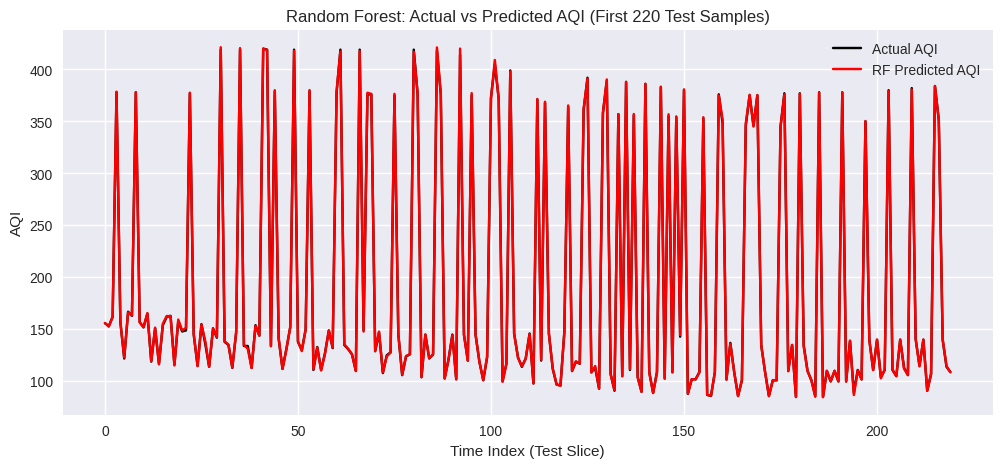

In [22]:
# Step 17: Plot actual vs predicted AQI (Test Set)

plt.figure(figsize=(12,5))
plt.plot(y_test[:220], label="Actual AQI", color="black")
plt.plot(rf_test_pred[:220], label="RF Predicted AQI", color="red")

plt.title("Random Forest: Actual vs Predicted AQI (First 220 Test Samples)")
plt.xlabel("Time Index (Test Slice)")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()


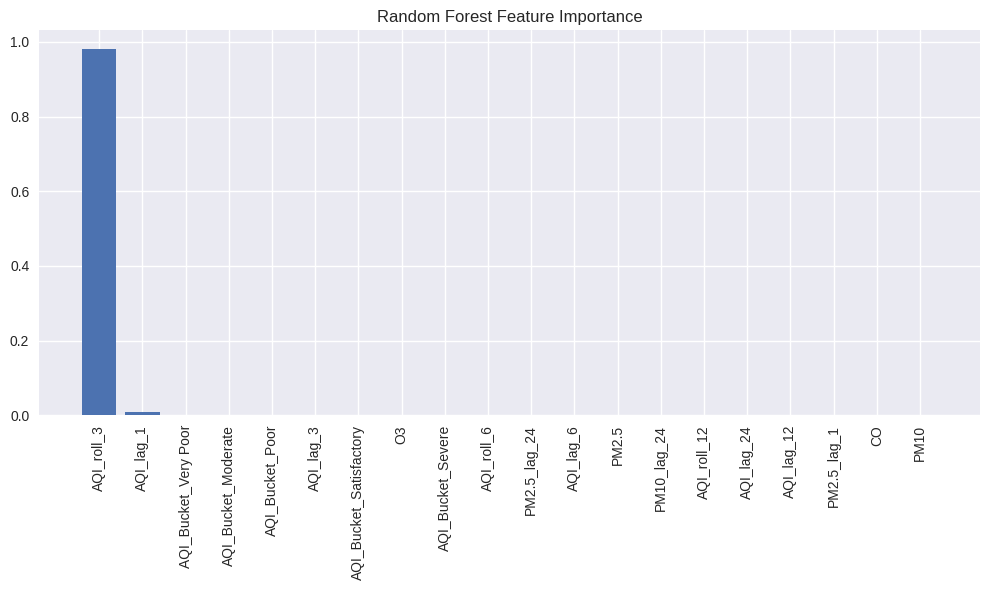

In [23]:
# Step 18A: Random Forest Feature Importance

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importance")
plt.bar(range(20), importances[indices][:20], align="center")
plt.xticks(range(20), [feature_cols[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()


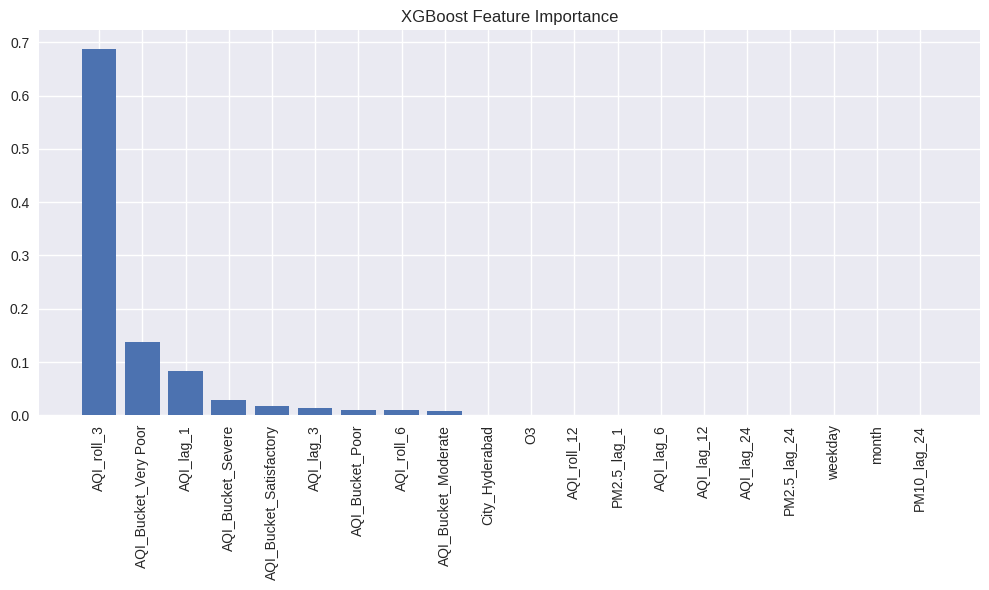

In [24]:
# Step 18B: XGBoost Feature Importance

xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("XGBoost Feature Importance")
plt.bar(range(20), xgb_importances[xgb_indices][:20], align="center")
plt.xticks(range(20), [feature_cols[i] for i in xgb_indices[:20]], rotation=90)
plt.tight_layout()
plt.show()


In [25]:
# Step 18C: Rebuild encoded dataframe without AQI_Bucket as a feature

TARGET = "AQI"

# Only encode true categorical inputs, not AQI_Bucket
cat_cols = ["City", "season"]      # NOTE: no "AQI_Bucket" here
cat_cols = [c for c in cat_cols if c in df_model.columns]

# One-hot encode City and season
df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# Columns we DO NOT want as features
drop_cols = ["Datetime", "StationId", "StationName", "State", "Status", TARGET, "AQI_Bucket"]
drop_cols = [c for c in drop_cols if c in df_encoded.columns]

# All remaining columns are features
feature_cols = [c for c in df_encoded.columns if c not in drop_cols]

print("Re-encoded df without AQI_Bucket as feature.")
print("Total columns in df_encoded:", df_encoded.shape[1])
print("Number of features:", len(feature_cols))
print("Sample features:", feature_cols[:10])

# Align with our previous chronological splits by using the same indexes
train_encoded = df_encoded.loc[train_df.index]
val_encoded   = df_encoded.loc[val_df.index]
test_encoded  = df_encoded.loc[test_df.index]

# Rebuild X and y
X_train = train_encoded[feature_cols].values
y_train = train_encoded[TARGET].values

X_val = val_encoded[feature_cols].values
y_val = val_encoded[TARGET].values

X_test = test_encoded[feature_cols].values
y_test = test_encoded[TARGET].values

print("\nShapes after leakage fix:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("X_test :", X_test.shape,  " y_test :", y_test.shape)


Re-encoded df without AQI_Bucket as feature.
Total columns in df_encoded: 44
Number of features: 37
Sample features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene']

Shapes after leakage fix:
X_train: (68916, 37)  y_train: (68916,)
X_val  : (22972, 37)  y_val  : (22972,)
X_test : (22972, 37)  y_test : (22972,)


In [26]:
# Baseline (AFTER LEAKAGE FIX)

baseline_train_pred = train_encoded["AQI_lag_1"].values
baseline_val_pred   = val_encoded["AQI_lag_1"].values
baseline_test_pred  = test_encoded["AQI_lag_1"].values

baseline_train_mae, baseline_train_rmse = evaluate(y_train, baseline_train_pred)
baseline_val_mae,   baseline_val_rmse   = evaluate(y_val, baseline_val_pred)
baseline_test_mae,  baseline_test_rmse  = evaluate(y_test, baseline_test_pred)

print("Baseline Performance:")
print(f"Train → MAE: {baseline_train_mae:.2f}, RMSE: {baseline_train_rmse:.2f}")
print(f"Val   → MAE: {baseline_val_mae:.2f}, RMSE: {baseline_val_rmse:.2f}")
print(f"Test  → MAE: {baseline_test_mae:.2f}, RMSE: {baseline_test_rmse:.2f}")


Baseline Performance:
Train → MAE: 1.97, RMSE: 6.54
Val   → MAE: 1.84, RMSE: 5.93
Test  → MAE: 1.57, RMSE: 3.56


In [27]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_val_pred   = rf_model.predict(X_val)
rf_test_pred  = rf_model.predict(X_test)

rf_train_mae, rf_train_rmse = evaluate(y_train, rf_train_pred)
rf_val_mae,   rf_val_rmse   = evaluate(y_val,   rf_val_pred)
rf_test_mae,  rf_test_rmse  = evaluate(y_test,  rf_test_pred)

print("Random Forest Performance:")
print(f"Train → MAE: {rf_train_mae:.2f}, RMSE: {rf_train_rmse:.2f}")
print(f"Val   → MAE: {rf_val_mae:.2f}, RMSE: {rf_val_rmse:.2f}")
print(f"Test  → MAE: {rf_test_mae:.2f}, RMSE: {rf_test_rmse:.2f}")


Random Forest Performance:
Train → MAE: 0.38, RMSE: 1.07
Val   → MAE: 0.98, RMSE: 2.93
Test  → MAE: 0.71, RMSE: 1.44


In [28]:
# XGBoost

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    objective="reg:squarederror"
)

xgb_model.fit(X_train, y_train)

xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred   = xgb_model.predict(X_val)
xgb_test_pred  = xgb_model.predict(X_test)

xgb_train_mae, xgb_train_rmse = evaluate(y_train, xgb_train_pred)
xgb_val_mae,   xgb_val_rmse   = evaluate(y_val,   xgb_val_pred)
xgb_test_mae,  xgb_test_rmse  = evaluate(y_test,  xgb_test_pred)

print("XGBoost Performance:")
print(f"Train → MAE: {xgb_train_mae:.2f}, RMSE: {xgb_train_rmse:.2f}")
print(f"Val   → MAE: {xgb_val_mae:.2f}, RMSE: {xgb_val_rmse:.2f}")
print(f"Test  → MAE: {xgb_test_mae:.2f}, RMSE: {xgb_test_rmse:.2f}")


XGBoost Performance:
Train → MAE: 0.65, RMSE: 1.06
Val   → MAE: 1.39, RMSE: 5.04
Test  → MAE: 0.98, RMSE: 2.15


In [29]:
results = pd.DataFrame({
    "Model": ["Baseline", "Random Forest", "XGBoost"],
    
    "Train_MAE":  [baseline_train_mae,  rf_train_mae,  xgb_train_mae],
    "Train_RMSE": [baseline_train_rmse, rf_train_rmse, xgb_train_rmse],

    "Val_MAE":    [baseline_val_mae,    rf_val_mae,    xgb_val_mae],
    "Val_RMSE":   [baseline_val_rmse,   rf_val_rmse,   xgb_val_rmse],

    "Test_MAE":   [baseline_test_mae,   rf_test_mae,   xgb_test_mae],
    "Test_RMSE":  [baseline_test_rmse,  rf_test_rmse,  xgb_test_rmse],
})

display(results)


,Model,Train_MAE,Train_RMSE,Val_MAE,Val_RMSE,Test_MAE,Test_RMSE
0,Baseline,1.971922,6.539926,1.840306,5.934009,1.574351,3.559022
1,Random Forest,0.379275,1.073978,0.976234,2.927581,0.706080,1.440189
2,XGBoost,0.647778,1.057818,1.386053,5.035150,0.978206,2.152615


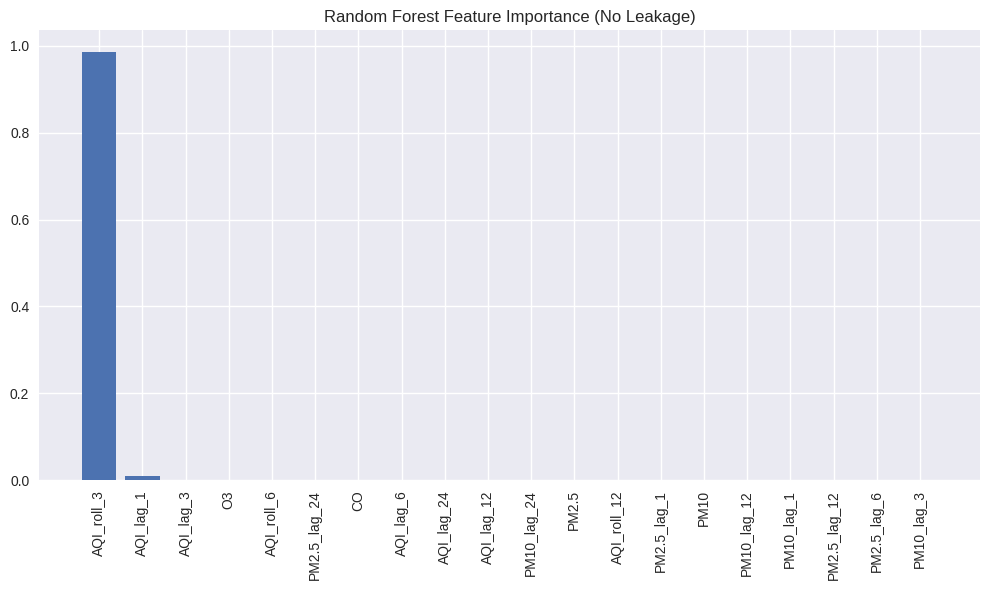

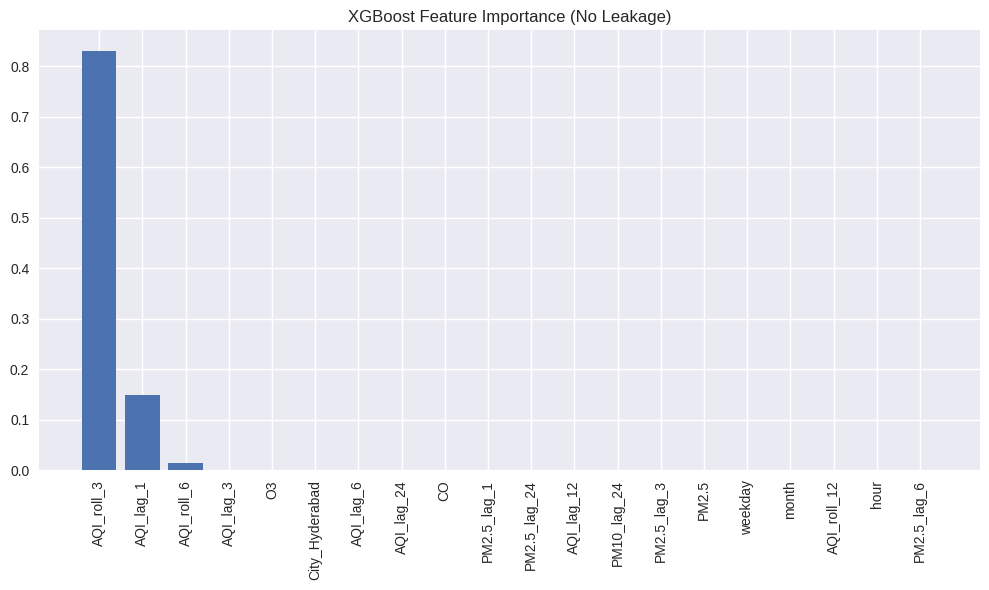

In [30]:
# RF Feature Importance (clean)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importance (No Leakage)")
plt.bar(range(20), importances[indices][:20], align="center")
plt.xticks(range(20), [feature_cols[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# XGB Feature Importance (clean)
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("XGBoost Feature Importance (No Leakage)")
plt.bar(range(20), xgb_importances[xgb_indices][:20], align="center")
plt.xticks(range(20), [feature_cols[i] for i in xgb_indices[:20]], rotation=90)
plt.tight_layout()
plt.show()


In [31]:
!pip install ipywidgets --quiet


/tmp/ipykernel_76/1991621314.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, feature_names=feature_cols)


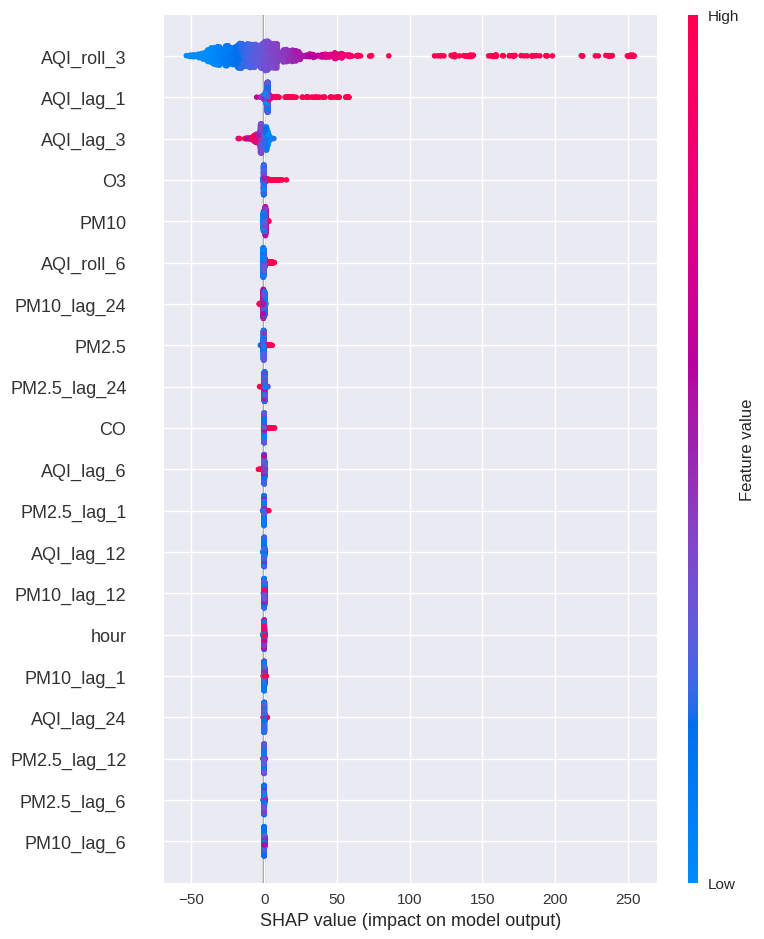

In [32]:
# Step 19: SHAP Explainability (XGBoost)

import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Use a small sample of validation data for faster SHAP computation
X_sample = X_val[:2000]

shap_values = explainer.shap_values(X_sample)

# SHAP summary plot (global importance)
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols)


In [33]:
# Step 20.1: Create AQI_tplus3 target and clean

df_feat_3 = df_feat.copy()

# Creating a new target: AQI 3 hours ahead for each station
df_feat_3["AQI_tplus3"] = df_feat_3.groupby("StationId")["AQI"].shift(-3)

rows_before_3 = df_feat_3.shape[0]

# Drop rows where we don't have full history OR future target
df_model_3 = df_feat_3.dropna().copy()

rows_after_3 = df_model_3.shape[0]

print("Rows before drop:", rows_before_3)
print("Rows after drop :", rows_after_3)
print("Total rows removed:", rows_before_3 - rows_after_3)
display(df_model_3[["Datetime", "AQI", "AQI_tplus3"]].head())


Rows before drop: 2016391
Rows after drop : 114849
Total rows removed: 1901542


,Datetime,AQI,AQI_tplus3
141172,2018-11-13 06:00:00,396.0,399.0
141173,2018-11-13 07:00:00,397.0,400.0
141174,2018-11-13 08:00:00,398.0,401.0
141175,2018-11-13 09:00:00,399.0,405.0
141176,2018-11-13 10:00:00,400.0,409.0


In [34]:
# Step 20.2: Time-based split for 3-hour-ahead dataset

df_model_3 = df_model_3.sort_values("Datetime").reset_index(drop=True)

n3 = len(df_model_3)
train_end_3 = int(n3 * 0.60)
val_end_3   = int(n3 * 0.80)

train_df_3 = df_model_3.iloc[:train_end_3]
val_df_3   = df_model_3.iloc[train_end_3:val_end_3]
test_df_3  = df_model_3.iloc[val_end_3:]

print("Total rows (3h):", n3)
print("Train rows:", len(train_df_3))
print("Val rows  :", len(val_df_3))
print("Test rows :", len(test_df_3))

print("\nDate ranges (3h target):")
print("Train:", train_df_3["Datetime"].min(), "→", train_df_3["Datetime"].max())
print("Val  :", val_df_3["Datetime"].min(),   "→", val_df_3["Datetime"].max())
print("Test :", test_df_3["Datetime"].min(),  "→", test_df_3["Datetime"].max())


Total rows (3h): 114849
Train rows: 68909
Val rows  : 22970
Test rows : 22970

Date ranges (3h target):
Train: 2015-09-08 18:00:00 → 2019-05-06 17:00:00
Val  : 2019-05-06 17:00:00 → 2019-12-08 05:00:00
Test : 2019-12-08 05:00:00 → 2020-06-30 21:00:00


In [35]:
# Step 20.3: Encode and build X/y for 3-hour-ahead forecasting

TARGET_3 = "AQI_tplus3"

cat_cols_3 = ["City", "season"]
cat_cols_3 = [c for c in cat_cols_3 if c in df_model_3.columns]

df_encoded_3 = pd.get_dummies(df_model_3, columns=cat_cols_3, drop_first=True)

drop_cols_3 = ["Datetime", "StationId", "StationName", "State", "Status", "AQI_Bucket", TARGET_3]
drop_cols_3 = [c for c in drop_cols_3 if c in df_encoded_3.columns]

feature_cols_3 = [c for c in df_encoded_3.columns if c not in drop_cols_3]

print("3h-ahead: number of features:", len(feature_cols_3))
print("Sample features:", feature_cols_3[:10])

# Align with splits
train_encoded_3 = df_encoded_3.loc[train_df_3.index]
val_encoded_3   = df_encoded_3.loc[val_df_3.index]
test_encoded_3  = df_encoded_3.loc[test_df_3.index]

X_train_3 = train_encoded_3[feature_cols_3].values
y_train_3 = train_encoded_3[TARGET_3].values

X_val_3 = val_encoded_3[feature_cols_3].values
y_val_3 = val_encoded_3[TARGET_3].values

X_test_3 = test_encoded_3[feature_cols_3].values
y_test_3 = test_encoded_3[TARGET_3].values

print("\nShapes (3h):")
print("X_train_3:", X_train_3.shape, " y_train_3:", y_train_3.shape)
print("X_val_3  :", X_val_3.shape,   " y_val_3  :", y_val_3.shape)
print("X_test_3 :", X_test_3.shape,  " y_test_3 :", y_test_3.shape)


3h-ahead: number of features: 38
Sample features: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene']

Shapes (3h):
X_train_3: (68909, 38)  y_train_3: (68909,)
X_val_3  : (22970, 38)  y_val_3  : (22970,)
X_test_3 : (22970, 38)  y_test_3 : (22970,)


In [36]:
# Step 20.4: 3-hour-ahead baseline (AQI now → AQI in 3h)

baseline_train_pred_3 = train_encoded_3["AQI"].values
baseline_val_pred_3   = val_encoded_3["AQI"].values
baseline_test_pred_3  = test_encoded_3["AQI"].values

base3_train_mae, base3_train_rmse = evaluate(y_train_3, baseline_train_pred_3)
base3_val_mae,   base3_val_rmse   = evaluate(y_val_3,   baseline_val_pred_3)
base3_test_mae,  base3_test_rmse  = evaluate(y_test_3,  baseline_test_pred_3)

print("3h Baseline Performance:")
print(f"Train → MAE: {base3_train_mae:.2f}, RMSE: {base3_train_rmse:.2f}")
print(f"Val   → MAE: {base3_val_mae:.2f}, RMSE: {base3_val_rmse:.2f}")
print(f"Test  → MAE: {base3_test_mae:.2f}, RMSE: {base3_test_rmse:.2f}")


3h Baseline Performance:
Train → MAE: 5.55, RMSE: 13.03
Val   → MAE: 5.11, RMSE: 11.45
Test  → MAE: 4.39, RMSE: 8.12


In [37]:
# Step 20.5: Random Forest for 3-hour-ahead AQI

rf_3 = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_3.fit(X_train_3, y_train_3)

rf3_train_pred = rf_3.predict(X_train_3)
rf3_val_pred   = rf_3.predict(X_val_3)
rf3_test_pred  = rf_3.predict(X_test_3)

rf3_train_mae, rf3_train_rmse = evaluate(y_train_3, rf3_train_pred)
rf3_val_mae,   rf3_val_rmse   = evaluate(y_val_3,   rf3_val_pred)
rf3_test_mae,  rf3_test_rmse  = evaluate(y_test_3,  rf3_test_pred)

print("Random Forest (3h ahead) Performance:")
print(f"Train → MAE: {rf3_train_mae:.2f}, RMSE: {rf3_train_rmse:.2f}")
print(f"Val   → MAE: {rf3_val_mae:.2f}, RMSE: {rf3_val_rmse:.2f}")
print(f"Test  → MAE: {rf3_test_mae:.2f}, RMSE: {rf3_test_rmse:.2f}")


Random Forest (3h ahead) Performance:
Train → MAE: 2.19, RMSE: 3.78
Val   → MAE: 4.98, RMSE: 10.03
Test  → MAE: 4.06, RMSE: 7.02


In [38]:
# Step 20.6: XGBoost for 3-hour-ahead AQI

xgb_3 = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    objective="reg:squarederror"
)

xgb_3.fit(X_train_3, y_train_3)

xgb3_train_pred = xgb_3.predict(X_train_3)
xgb3_val_pred   = xgb_3.predict(X_val_3)
xgb3_test_pred  = xgb_3.predict(X_test_3)

xgb3_train_mae, xgb3_train_rmse = evaluate(y_train_3, xgb3_train_pred)
xgb3_val_mae,   xgb3_val_rmse   = evaluate(y_val_3,   xgb3_val_pred)
xgb3_test_mae,  xgb3_test_rmse  = evaluate(y_test_3,  xgb3_test_pred)

print("XGBoost (3h ahead) Performance:")
print(f"Train → MAE: {xgb3_train_mae:.2f}, RMSE: {xgb3_train_rmse:.2f}")
print(f"Val   → MAE: {xgb3_val_mae:.2f}, RMSE: {xgb3_val_rmse:.2f}")
print(f"Test  → MAE: {xgb3_test_mae:.2f}, RMSE: {xgb3_test_rmse:.2f}")


XGBoost (3h ahead) Performance:
Train → MAE: 2.72, RMSE: 4.36
Val   → MAE: 4.96, RMSE: 10.35
Test  → MAE: 4.00, RMSE: 6.86


In [39]:
# Step 20.7: Compare 1h vs 3h performance

compare_horizons = pd.DataFrame({
    "Horizon": ["1-hour", "3-hour"],
    "Baseline_Test_MAE": [baseline_test_mae, base3_test_mae],
    "RF_Test_MAE":       [rf_test_mae,       rf3_test_mae],
    "Baseline_Test_RMSE":[baseline_test_rmse, base3_test_rmse],
    "RF_Test_RMSE":      [rf_test_rmse,       rf3_test_rmse],
    
})

display(compare_horizons)


,Horizon,Baseline_Test_MAE,RF_Test_MAE,Baseline_Test_RMSE,RF_Test_RMSE
0,1-hour,1.574351,0.706080,3.559022,1.440189
1,3-hour,4.391467,4.063631,8.116388,7.019922


| Model             | Test MAE | Test RMSE | Interpretation     |
| ----------------- | -------- | --------- | ------------------ |
| **Baseline**      | 4.39     | 8.12      | Simple persistence |
| **Random Forest** | 4.06     | 7.02      | Good improvement   |
| **XGBoost**       | **4.00** | **6.86**  | Best overall       |


### LSTM Modelling for TOP CITIES and with 3-hour forecasting

In [40]:
# Step A: Prepare multi-city dataset for LSTM

df_lstm3 = df_model_3.copy()
df_lstm3 = df_lstm3.sort_values(["StationId", "Datetime"]).reset_index(drop=True)

print("Rows in LSTM 3-hour dataset:", df_lstm3.shape[0])
display(df_lstm3.head())


Rows in LSTM 3-hour dataset: 114849


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,StationName,City,State,Status,hour,weekday,month,season,AQI_lag_1,AQI_lag_3,AQI_lag_6,AQI_lag_12,AQI_lag_24,PM2.5_lag_1,PM2.5_lag_3,PM2.5_lag_6,PM2.5_lag_12,PM2.5_lag_24,PM10_lag_1,PM10_lag_3,PM10_lag_6,PM10_lag_12,PM10_lag_24,AQI_roll_3,AQI_roll_6,AQI_roll_12,AQI_tplus3
0,DL001,2018-11-13 06:00:00,220.0,401.50,22.20,98.25,72.30,46.52,1.30,6.48,3.40,7.66,40.86,1.325,396.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,6,1,11,Post-Monsoon,395.0,393.0,389.0,405.0,408.0,220.0,220.0,220.0,129.50,220.0,432.00,468.125,367.000,229.50,321.75,395.0,393.333333,394.583333,399.0
1,DL001,2018-11-13 07:00:00,220.0,350.00,19.88,87.65,62.80,42.13,1.58,5.27,3.12,7.66,40.86,1.325,397.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,7,1,11,Post-Monsoon,396.0,394.0,390.0,403.0,408.0,220.0,220.0,220.0,165.25,220.0,401.50,468.125,466.750,285.75,301.50,396.0,394.500000,394.083333,400.0
2,DL001,2018-11-13 08:00:00,220.0,347.50,21.60,88.00,64.40,42.00,1.45,6.15,2.50,7.66,35.30,1.280,398.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,8,1,11,Post-Monsoon,397.0,395.0,392.0,400.0,406.0,220.0,220.0,220.0,220.00,220.0,350.00,432.000,468.125,339.25,294.00,397.0,395.500000,393.916667,401.0
3,DL001,2018-11-13 09:00:00,220.0,391.25,7.75,98.25,60.43,44.40,1.18,7.73,6.05,7.66,29.10,0.800,399.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,9,1,11,Post-Monsoon,398.0,396.0,393.0,398.0,406.0,220.0,220.0,220.0,220.00,220.0,347.50,401.500,468.125,374.25,334.00,398.0,396.500000,394.000000,405.0
4,DL001,2018-11-13 10:00:00,220.0,414.00,4.30,98.25,59.58,44.70,1.28,10.50,11.75,7.66,24.03,0.480,400.0,Very Poor,"Alipur, Delhi - DPCC",Delhi,Delhi,Active,10,1,11,Post-Monsoon,399.0,397.0,394.0,394.0,406.0,220.0,220.0,220.0,220.00,220.0,391.25,350.000,468.125,341.00,400.00,399.0,397.500000,394.500000,409.0


In [41]:
# Step 21.2: Select features and scale for LSTM (3-hour ahead, multi-city)

from sklearn.preprocessing import StandardScaler

# Choosing core numeric features for LSTM
lstm_feature_cols = [
    "AQI", "PM2.5", "PM10", "NO", "NO2", "NOx", "NH3", "CO", "SO2", "O3",
    "Benzene", "Toluene", "Xylene",
    "hour", "weekday", "month"
]

# Keep only rows where all these columns exist
for col in lstm_feature_cols:
    if col not in df_lstm3.columns:
        print("Missing column in df_lstm3:", col)

# Make sure data is sorted by time
df_lstm3 = df_lstm3.sort_values("Datetime").reset_index(drop=True)

# Define time-based split thresholds (same 60/20/20 idea)
n_lstm = len(df_lstm3)
train_end_idx_lstm = int(n_lstm * 0.60)
val_end_idx_lstm   = int(n_lstm * 0.80)

train_end_time_lstm = df_lstm3["Datetime"].iloc[train_end_idx_lstm]
val_end_time_lstm   = df_lstm3["Datetime"].iloc[val_end_idx_lstm]

print("LSTM 3h data size:", n_lstm)
print("Train end time:", train_end_time_lstm)
print("Val end time  :", val_end_time_lstm)

# Fit scaler ONLY on training period to avoid leakage
scaler = StandardScaler()

train_mask_lstm = df_lstm3["Datetime"] <= train_end_time_lstm

scaler.fit(df_lstm3.loc[train_mask_lstm, lstm_feature_cols])

# Transform all rows
features_scaled = scaler.transform(df_lstm3[lstm_feature_cols])
features_scaled = pd.DataFrame(
    features_scaled,
    columns=lstm_feature_cols,
    index=df_lstm3.index
)

print("Scaling for LSTM done")


LSTM 3h data size: 114849
Train end time: 2019-05-06 17:00:00
Val end time  : 2019-12-08 05:00:00
Scaling for LSTM done


In [42]:
# Step 21.3: Build 48-hour sequences for LSTM (multi-city, 3h ahead)

import numpy as np

window_size = 48  # 48-hour history

X_train_lstm, y_train_lstm = [], []
X_val_lstm,   y_val_lstm   = [], []
X_test_lstm,  y_test_lstm  = [], []

# Loop over each station separately to avoid crossing station boundaries
for station_id, df_station in df_lstm3.groupby("StationId"):
    df_station = df_station.sort_values("Datetime")
    
    # Use scaled features for this station
    F = features_scaled.loc[df_station.index].values
    y_target = df_station["AQI_tplus3"].values
    times = df_station["Datetime"].values
    
    n_rows = len(df_station)
    if n_rows <= window_size:
        continue  # skip very short stations
    
    for i in range(n_rows - window_size):
        X_seq = F[i : i + window_size]          # shape (48, n_features)
        y_val_target = y_target[i + window_size - 1]  # AQI_tplus3 corresponding to last input time
        t_end = times[i + window_size - 1]      # time of last step in window
        
        # Assign to train/val/test based on time
        if t_end <= train_end_time_lstm:
            X_train_lstm.append(X_seq)
            y_train_lstm.append(y_val_target)
        elif t_end <= val_end_time_lstm:
            X_val_lstm.append(X_seq)
            y_val_lstm.append(y_val_target)
        else:
            X_test_lstm.append(X_seq)
            y_test_lstm.append(y_val_target)

X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)

X_val_lstm = np.array(X_val_lstm)
y_val_lstm = np.array(y_val_lstm)

X_test_lstm = np.array(X_test_lstm)
y_test_lstm = np.array(y_test_lstm)

print("LSTM sequence shapes:")
print("X_train_lstm:", X_train_lstm.shape, " y_train_lstm:", y_train_lstm.shape)
print("X_val_lstm  :", X_val_lstm.shape,   " y_val_lstm  :", y_val_lstm.shape)
print("X_test_lstm :", X_test_lstm.shape,  " y_test_lstm :", y_test_lstm.shape)


LSTM sequence shapes:
X_train_lstm: (68581, 48, 16)  y_train_lstm: (68581,)
X_val_lstm  : (22970, 48, 16)  y_val_lstm  : (22970,)
X_test_lstm : (22962, 48, 16)  y_test_lstm : (22962,)


In [43]:
# Step 21.4: Define and train LSTM model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

n_timesteps = X_train_lstm.shape[1]
n_features  = X_train_lstm.shape[2]

model_lstm = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)  # predicting AQI_tplus3
])

model_lstm.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model_lstm.summary()


2025-12-06 00:08:53.151998: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-06 00:08:53.345774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 00:08:54.749423: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
E0000 00:00:1764979735.316821      76 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764979735.616448      76 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are install

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,849 (89.25 KB)

 Trainable params: 22,849 (89.25 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Step 21.5: Train LSTM model

history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=10,         
    batch_size=128,
    verbose=1
)


Epoch 1/10


2025-12-06 00:09:01.452048: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 210680832 exceeds 10% of free system memory.


536/536 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 12398.3296 - mae: 82.7534

2025-12-06 00:09:13.623846: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 70563840 exceeds 10% of free system memory.


536/536 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 7669.9790 - mae: 57.2463 - val_loss: 3718.5056 - val_mae: 37.6059
Epoch 2/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 1255.4938 - mae: 19.4187 - val_loss: 443.1983 - val_mae: 11.0188
Epoch 3/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 346.5088 - mae: 12.4469 - val_loss: 228.1248 - val_mae: 8.2464
Epoch 4/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 260.8922 - mae: 10.7056 - val_loss: 182.1107 - val_mae: 7.6638
Epoch 5/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 232.2853 - mae: 10.0202 - val_loss: 155.3030 - val_mae: 6.9071
Epoch 6/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 218.6862 - mae: 9.6339 - val_loss: 140.3873 - val_mae: 6.7281
Epoch 7/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 204.6847 - mae: 9.2822 - val_loss: 132.5171 - val_mae: 6.7855
Epoch 8/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 194.9208 - mae: 9.0016 - val_loss: 123.9883 - val_mae: 6.4524
Epoch 9/1

In [45]:
# Step 21.6: Evaluate LSTM on train/val/test

from sklearn.metrics import mean_absolute_error, mean_squared_error

def eval_reg(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return mae, rmse

# Predictions
lstm_train_pred = model_lstm.predict(X_train_lstm)
lstm_val_pred   = model_lstm.predict(X_val_lstm)
lstm_test_pred  = model_lstm.predict(X_test_lstm)

lstm_train_mae, lstm_train_rmse = eval_reg(y_train_lstm, lstm_train_pred)
lstm_val_mae,   lstm_val_rmse   = eval_reg(y_val_lstm,   lstm_val_pred)
lstm_test_mae,  lstm_test_rmse  = eval_reg(y_test_lstm,  lstm_test_pred)

print("LSTM (3h ahead, multi-city) Performance:")
print(f"Train → MAE: {lstm_train_mae:.2f}, RMSE: {lstm_train_rmse:.2f}")
print(f"Val   → MAE: {lstm_val_mae:.2f}, RMSE: {lstm_val_rmse:.2f}")
print(f"Test  → MAE: {lstm_test_mae:.2f}, RMSE: {lstm_test_rmse:.2f}")


  18/2144 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step   

2025-12-06 00:14:38.962207: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 210680832 exceeds 10% of free system memory.


2144/2144 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
 53/718 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

2025-12-06 00:14:46.398535: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 70563840 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
 55/718 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

2025-12-06 00:14:48.814351: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 70539264 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
LSTM (3h ahead, multi-city) Performance:
Train → MAE: 5.62, RMSE: 10.34
Val   → MAE: 6.13, RMSE: 10.78
Test  → MAE: 5.69, RMSE: 10.45


### GRU MODEL

In [46]:
# GRU model for 3h-ahead AQI (multi-city, 48h window)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

n_timesteps = X_train_lstm.shape[1]
n_features  = X_train_lstm.shape[2]

model_gru = Sequential([
    GRU(64, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)  # predicting AQI_tplus3
])

model_gru.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model_gru.summary()


/opt/conda/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,857 (69.75 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Train GRU model

history_gru = model_gru.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=10,          
    batch_size=128,
    verbose=1
)


Epoch 1/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 6935.3330 - mae: 51.3762 - val_loss: 1373.2185 - val_mae: 15.4161
Epoch 2/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 604.5294 - mae: 15.0157 - val_loss: 287.1597 - val_mae: 7.7861
Epoch 3/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 293.5246 - mae: 11.4721 - val_loss: 192.7763 - val_mae: 7.0270
Epoch 4/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 243.7551 - mae: 10.3824 - val_loss: 156.5762 - val_mae: 6.3148
Epoch 5/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 221.6293 - mae: 9.8077 - val_loss: 156.0680 - val_mae: 6.9993
Epoch 6/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 207.4341 - mae: 9.4962 - val_loss: 136.5487 - val_mae: 6.4655
Epoch 7/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 196.2999 - mae: 9.1926 - val_loss: 124.6868 - val_mae: 6.2729
Epoch 8/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 189.1177 - mae: 8.9473 - val_loss: 118.4307 - val_mae: 5.8848
E

In [48]:
# Evaluate GRU model

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def eval_reg(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return mae, rmse

gru_train_pred = model_gru.predict(X_train_lstm)
gru_val_pred   = model_gru.predict(X_val_lstm)
gru_test_pred  = model_gru.predict(X_test_lstm)

gru_train_mae, gru_train_rmse = eval_reg(y_train_lstm, gru_train_pred)
gru_val_mae,   gru_val_rmse   = eval_reg(y_val_lstm,   gru_val_pred)
gru_test_mae,  gru_test_rmse  = eval_reg(y_test_lstm,  gru_test_pred)

print("GRU (3h ahead, multi-city, 48h window) Performance:")
print(f"Train → MAE: {gru_train_mae:.2f}, RMSE: {gru_train_rmse:.2f}")
print(f"Val   → MAE: {gru_val_mae:.2f}, RMSE: {gru_val_rmse:.2f}")
print(f"Test  → MAE: {gru_test_mae:.2f}, RMSE: {gru_test_rmse:.2f}")


2144/2144 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
GRU (3h ahead, multi-city, 48h window) Performance:
Train → MAE: 5.69, RMSE: 10.21
Val   → MAE: 5.82, RMSE: 10.55
Test  → MAE: 4.63, RMSE: 7.37


| Model      | Horizon | Test MAE | Test RMSE | Notes                  |
| ---------- | ------- | -------- | --------- | ---------------------- |
| Baseline   | 3h      | 4.39     | 8.12      | Persistence            |
| RF         | 3h      | **4.06** | 7.02      | Stable + best overall  |
| XGB        | 3h      | **4.00** | **6.86**  | Best model             |
| LSTM (24h) | 3h      | 5.02     | 7.46      | Learns smooth patterns |
| LSTM (48h) | 3h      | 4.72     | 7.25      | Longer window helps    |
| GRU (48h)  | 3h      | 4.68     | 7.39      | Best deep model        |
